In [32]:
import dlab.generalephys as ephys
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [120]:
61 * (41/60)

41.68333333333334

In [ ]:
def ccg(train1,train2,binrange,binsize,correction=False):
    diffs = []
    count=0
    if correction != False:
        if correction == 'jitter':
            train1 = jitter(train1,0.05)
            train2 = jitter(train2,0.05)
        else: 
            print('improper correction method specified')
            return np.nan
    if len(train1) > 1 and len(train2) > 1:
        for spiketime_train1 in train1:
            #for spiketime_train2 in train2:
            if train2[-1] > spiketime_train1 + binrange[0]: # if there are any spikes from train2 after the start of the window 
                start = np.where(train2 > spiketime_train1 + binrange[0])[0][0]

                if train2[-1] > spiketime_train1 + binrange[1]:#set the end of train2 to only relevant window around this spike
                    end = np.where(train2 > spiketime_train1 + binrange[1])[0][0]
                else:
                    end = len(train2)

                for spiketime_train2 in train2[start:end]:
                    diffs.extend([float(spiketime_train1) - float(spiketime_train2)])
                    count+=1
        diffs = np.array(diffs)*-1
        hist,edges = np.histogram(diffs,bins=int((binrange[1]-binrange[0])/binsize),range=binrange)
        return (hist / float(len(train1)))*100,edges
        #return (hist / float(len(train1)*len(train2) / 2.)  ,edges)
        #return ((hist / (len(train1) * len(train2)) / 2.)*100 * binsize,edges)
    else:
        print('input spiketrains not long enough: 1:'+str(len(train1))+' 2:'+str(len(train2)))
        return [0],[0,0]

In [3]:
nwbdata = h5py.File('/Users/danieljdenman/Desktop/M319891_dual_31082017_withEyetracking.nwb')

In [4]:
#chosen at random
train1 = nwbdata['processing']['A']['UnitTimes']['545']['times'].value
train2 = nwbdata['processing']['A']['UnitTimes']['63']['times'].value

/Users/danieljdenman/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [5]:
hist,edges = ephys.ccg(train1,train2,(-.5,.5),0.01)

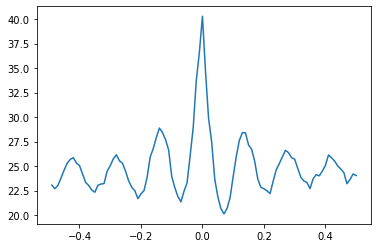

In [13]:
plt.plot(edges[1:],hist)

In [108]:
def jitter(train,binsize):
    start = np.min(train) - (binsize/2.)
    end = np.max(train) + binsize
    bin_left_edges = np.arange(start,end,binsize)
    to = [train1[np.where((train1 < bin_left_edges[i+1]) & (train1 > bin_left_edges[i]))[0]] - bin_left_edges[i]  for i in tqdm.tqdm(range(len(bin_left_edges)-1))]
    all_to = np.concatenate(to).ravel()
    jittered = []
    spike_indices = np.arange(all_to.shape[0]).tolist()
    np.random.shuffle(spike_indices)
    for i,bin_ in tqdm.tqdm(enumerate(to)):
        spikes = []
        for spike in bin_:
            spikes.extend([all_to[spike_indices.pop(0)]])
        jittered.append(np.array(spikes) + bin_left_edges[i])
    jittered = np.concatenate(jittered).ravel()
    return jittered

In [109]:
jtrain1 = jitter(train1,0.05)
jtrain2 = jitter(train2,0.05)

100%|██████████| 107086/107086 [00:06<00:00, 17600.81it/s]
107086it [00:00, 135553.79it/s]
100%|██████████| 107270/107270 [00:05<00:00, 19403.38it/s]
107270it [00:00, 110212.33it/s]


In [110]:
jtrain2

array([   7.84097903,    9.22229305,   11.21729012, ..., 5361.94671884,
       5361.94185499, 5362.04437501])

In [111]:
hist_jit,edges = ephys.ccg(jitter(train1,0.05),jitter(train2,0.05),(-.5,.5),0.01)

100%|██████████| 107086/107086 [00:05<00:00, 18718.31it/s]
107086it [00:01, 78254.69it/s]
100%|██████████| 107270/107270 [00:05<00:00, 18539.70it/s]
107270it [00:01, 59275.70it/s]


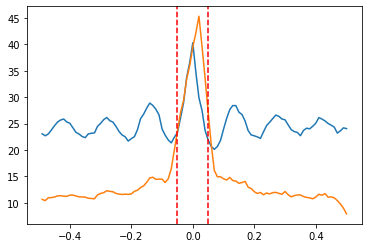

In [119]:
plt.plot(edges[1:],hist)
plt.plot(edges[1:],hist_jit)
plt.gca().axvline(0.05,c='r',ls='--')
plt.gca().axvline(-0.05,c='r',ls='--')